In [7]:
# Install required packages
get_ipython().system('pip install numpy')

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import time


In [2]:
# Load UCI-HAR dataset function (from research[91])
def load_dataset_group(group, prefix=''):
    # Load input features (561 features)
    X = pd.read_csv(prefix + group + '/X_'+group+'.txt',
                    header=None, delim_whitespace=True)
    # Load activity labels
    y = pd.read_csv(prefix + group + '/y_'+group+'.txt',
                    header=None, delim_whitespace=True)
    return X.values, y.values.flatten()

def load_uci_har_dataset(prefix='/content/drive/MyDrive/UCI HAR Dataset/'):
    # Load training data
    trainX, trainy = load_dataset_group('train', prefix)
    # Load test data
    testX, testy = load_dataset_group('test', prefix)

    print(f"Training data: {trainX.shape}, Training labels: {trainy.shape}")
    print(f"Test data: {testX.shape}, Test labels: {testy.shape}")

    return trainX, trainy, testX, testy

# Load the dataset
trainX, trainy, testX, testy = load_uci_har_dataset()


/tmp/ipython-input-1648820390.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv(prefix + group + '/X_'+group+'.txt',
/tmp/ipython-input-1648820390.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(prefix + group + '/y_'+group+'.txt',
/tmp/ipython-input-1648820390.py:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X = pd.read_csv(prefix + group + '/X_'+group+'.txt',
/tmp/ipython-input-1648820390.py:7: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  y = pd.read_csv(prefix + group + '/y_'+group+'.txt',


Training data: (7352, 561), Training labels: (7352,)
Test data: (2947, 561), Test labels: (2947,)


In [3]:
def extract_time_domain_features(data):
    """
    Extract time-domain statistical features from sensor data
    Based on research findings[31][100]
    """
    features = []

    # For each sensor axis (561 features -> extract from raw signals)
    for i in range(data.shape[1]):
        signal = data[:, i]

        # Basic statistical features
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        var_val = np.var(signal)
        min_val = np.min(signal)
        max_val = np.max(signal)

        # Higher-order moments
        skewness = np.mean(((signal - mean_val) / std_val) ** 3) if std_val > 0 else 0
        kurtosis = np.mean(((signal - mean_val) / std_val) ** 4) if std_val > 0 else 0

        # Energy and power features
        rms = np.sqrt(np.mean(signal ** 2))
        energy = np.sum(signal ** 2)

        features.extend([mean_val, std_val, var_val, min_val, max_val,
                        skewness, kurtosis, rms, energy])

    return np.array(features)

def extract_frequency_domain_features(data):
    """
    Extract frequency-domain features using FFT
    Based on research findings[89][100]
    """
    features = []

    for i in range(data.shape[1]):
        signal = data[:, i]

        # Apply FFT
        fft_vals = np.fft.fft(signal)
        fft_magnitude = np.abs(fft_vals)

        # Frequency domain features
        spectral_centroid = np.sum(fft_magnitude * np.arange(len(fft_magnitude))) / np.sum(fft_magnitude)
        spectral_rolloff = np.percentile(fft_magnitude, 85)
        spectral_energy = np.sum(fft_magnitude ** 2)

        # Peak frequency
        peak_freq = np.argmax(fft_magnitude)

        features.extend([spectral_centroid, spectral_rolloff, spectral_energy, peak_freq])

    return np.array(features)

# Extract features for all samples
def extract_all_features(X):
    """Extract both time and frequency domain features"""
    all_features = []

    for i in range(X.shape[0]):
        sample = X[i].reshape(1, -1)  # Reshape for processing

        # Extract time-domain features (limited to first 50 for simplicity)
        time_features = extract_time_domain_features(sample[:, :50])

        # Extract frequency-domain features (limited to first 50 for simplicity)
        freq_features = extract_frequency_domain_features(sample[:, :50])

        # Combine features
        combined_features = np.concatenate([time_features, freq_features])
        all_features.append(combined_features)

    return np.array(all_features)

# For simplicity, use pre-extracted UCI-HAR features (561 features)
# This represents the "handcrafted features" from the base paper
X_features_train = trainX  # Already extracted features
X_features_test = testX


In [4]:
def apply_pca_reduction(X_train, X_test, n_components_list=[10, 20, 30]):
    """
    Apply PCA dimensionality reduction with different component numbers
    Based on research[93][98]
    """
    results = {}

    # Standardize the data first
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for n_comp in n_components_list:
        print(f"Applying PCA with {n_comp} components...")

        # Apply PCA
        pca = PCA(n_components=n_comp, random_state=42)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Calculate explained variance ratio
        explained_variance = np.sum(pca.explained_variance_ratio_)

        results[f'PCA_{n_comp}'] = {
            'X_train': X_train_pca,
            'X_test': X_test_pca,
            'explained_variance': explained_variance,
            'n_components': n_comp
        }

        print(f"Explained variance with {n_comp} components: {explained_variance:.3f}")

    return results

# Apply PCA
pca_results = apply_pca_reduction(X_features_train, X_features_test)


Applying PCA with 10 components...
Explained variance with 10 components: 0.708
Applying PCA with 20 components...
Explained variance with 20 components: 0.774
Applying PCA with 30 components...
Explained variance with 30 components: 0.818


In [5]:
def apply_lda_reduction(X_train, X_test, y_train, n_components_list=[5]):
    """
    Apply LDA dimensionality reduction
    Note: LDA can have at most n_classes-1 components (5 for 6 classes)
    Based on research[96][99]
    """
    results = {}

    # Standardize the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # LDA can have at most n_classes-1 components
    max_components = len(np.unique(y_train)) - 1  # 5 for 6 activity classes

    for n_comp in n_components_list:
        if n_comp > max_components:
            n_comp = max_components

        print(f"Applying LDA with {n_comp} components...")

        # Apply LDA
        lda = LDA(n_components=n_comp)
        X_train_lda = lda.fit_transform(X_train_scaled, y_train)
        X_test_lda = lda.transform(X_test_scaled)

        # Calculate explained variance ratio
        explained_variance = np.sum(lda.explained_variance_ratio_) if hasattr(lda, 'explained_variance_ratio_') else "N/A"

        results[f'LDA_{n_comp}'] = {
            'X_train': X_train_lda,
            'X_test': X_test_lda,
            'explained_variance': explained_variance,
            'n_components': n_comp
        }

    return results

# Apply LDA (maximum 5 components for 6 classes)
lda_results = apply_lda_reduction(X_features_train, X_features_test, trainy, [5])


Applying LDA with 5 components...


In [6]:
def train_classifiers(X_train, X_test, y_train, y_test, method_name):
    """
    Train SVM, Random Forest, and k-NN classifiers
    Based on research[101][103][106]
    """
    results = {}

    # Define classifiers
    classifiers = {
        'SVM': SVC(kernel='rbf', random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'k-NN': KNeighborsClassifier(n_neighbors=5)
    }

    for clf_name, clf in classifiers.items():
        print(f"Training {clf_name} on {method_name}...")

        # Measure training time
        start_time = time.time()
        clf.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Measure inference time and make predictions
        start_time = time.time()
        y_pred = clf.predict(X_test)
        inference_time = time.time() - start_time

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Get model size (approximate)
        model_size = clf.__sizeof__()  # Basic size estimation

        results[clf_name] = {
            'accuracy': accuracy,
            'training_time': training_time,
            'inference_time': inference_time,
            'model_size': model_size,
            'predictions': y_pred
        }

        print(f"{clf_name} - Accuracy: {accuracy:.3f}, Training time: {training_time:.3f}s")

    return results

In [7]:
def comprehensive_evaluation():
    """
    Evaluate all combinations of methods and classifiers
    """
    all_results = {}

    # Original features (baseline)
    print("=== Evaluating Original Features ===")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_features_train)
    X_test_scaled = scaler.transform(X_features_test)

    all_results['Original'] = train_classifiers(
        X_train_scaled, X_test_scaled, trainy, testy, "Original Features"
    )

    # PCA reduced features
    for pca_key, pca_data in pca_results.items():
        print(f"=== Evaluating {pca_key} ===")
        all_results[pca_key] = train_classifiers(
            pca_data['X_train'], pca_data['X_test'],
            trainy, testy, pca_key
        )

    # LDA reduced features
    for lda_key, lda_data in lda_results.items():
        print(f"=== Evaluating {lda_key} ===")
        all_results[lda_key] = train_classifiers(
            lda_data['X_train'], lda_data['X_test'],
            trainy, testy, lda_key
        )

    return all_results

# Run comprehensive evaluation
evaluation_results = comprehensive_evaluation()


=== Evaluating Original Features ===
Training SVM on Original Features...
SVM - Accuracy: 0.952, Training time: 3.026s
Training Random Forest on Original Features...
Random Forest - Accuracy: 0.926, Training time: 22.311s
Training k-NN on Original Features...
k-NN - Accuracy: 0.880, Training time: 0.017s
=== Evaluating PCA_10 ===
Training SVM on PCA_10...
SVM - Accuracy: 0.846, Training time: 0.723s
Training Random Forest on PCA_10...
Random Forest - Accuracy: 0.825, Training time: 3.221s
Training k-NN on PCA_10...
k-NN - Accuracy: 0.814, Training time: 0.010s
=== Evaluating PCA_20 ===
Training SVM on PCA_20...
SVM - Accuracy: 0.875, Training time: 0.402s
Training Random Forest on PCA_20...
Random Forest - Accuracy: 0.856, Training time: 4.285s
Training k-NN on PCA_20...
k-NN - Accuracy: 0.834, Training time: 0.001s
=== Evaluating PCA_30 ===
Training SVM on PCA_30...
SVM - Accuracy: 0.894, Training time: 0.515s
Training Random Forest on PCA_30...
Random Forest - Accuracy: 0.862, Traini

In [8]:
def create_results_summary(results):
    """
    Create a comprehensive results summary table
    """
    summary_data = []

    for method_name, method_results in results.items():
        for classifier_name, clf_results in method_results.items():
            summary_data.append({
                'Method': method_name,
                'Classifier': classifier_name,
                'Accuracy': clf_results['accuracy'],
                'Training_Time': clf_results['training_time'],
                'Inference_Time': clf_results['inference_time'],
                'Model_Size': clf_results['model_size']
            })

    return pd.DataFrame(summary_data)

# Create and display results summary
results_df = create_results_summary(evaluation_results)
print("\n=== COMPREHENSIVE RESULTS SUMMARY ===")
print(results_df.round(4))

# Save results to CSV
results_df.to_csv('uci_har_dimensionality_reduction_results.csv', index=False)
print("\nResults saved to 'uci_har_dimensionality_reduction_results.csv'")



=== COMPREHENSIVE RESULTS SUMMARY ===
      Method     Classifier  Accuracy  Training_Time  Inference_Time  \
0   Original            SVM    0.9522         3.0258          5.3638   
1   Original  Random Forest    0.9260        22.3109          0.0639   
2   Original           k-NN    0.8802         0.0173          1.7041   
3     PCA_10            SVM    0.8456         0.7234          0.9395   
4     PCA_10  Random Forest    0.8249         3.2207          0.0437   
5     PCA_10           k-NN    0.8140         0.0101          0.0702   
6     PCA_20            SVM    0.8755         0.4020          0.5091   
7     PCA_20  Random Forest    0.8558         4.2849          0.0480   
8     PCA_20           k-NN    0.8341         0.0014          0.1359   
9     PCA_30            SVM    0.8941         0.5149          0.5800   
10    PCA_30  Random Forest    0.8622         6.4594          0.0485   
11    PCA_30           k-NN    0.8426         0.0015          0.1588   
12     LDA_5            S

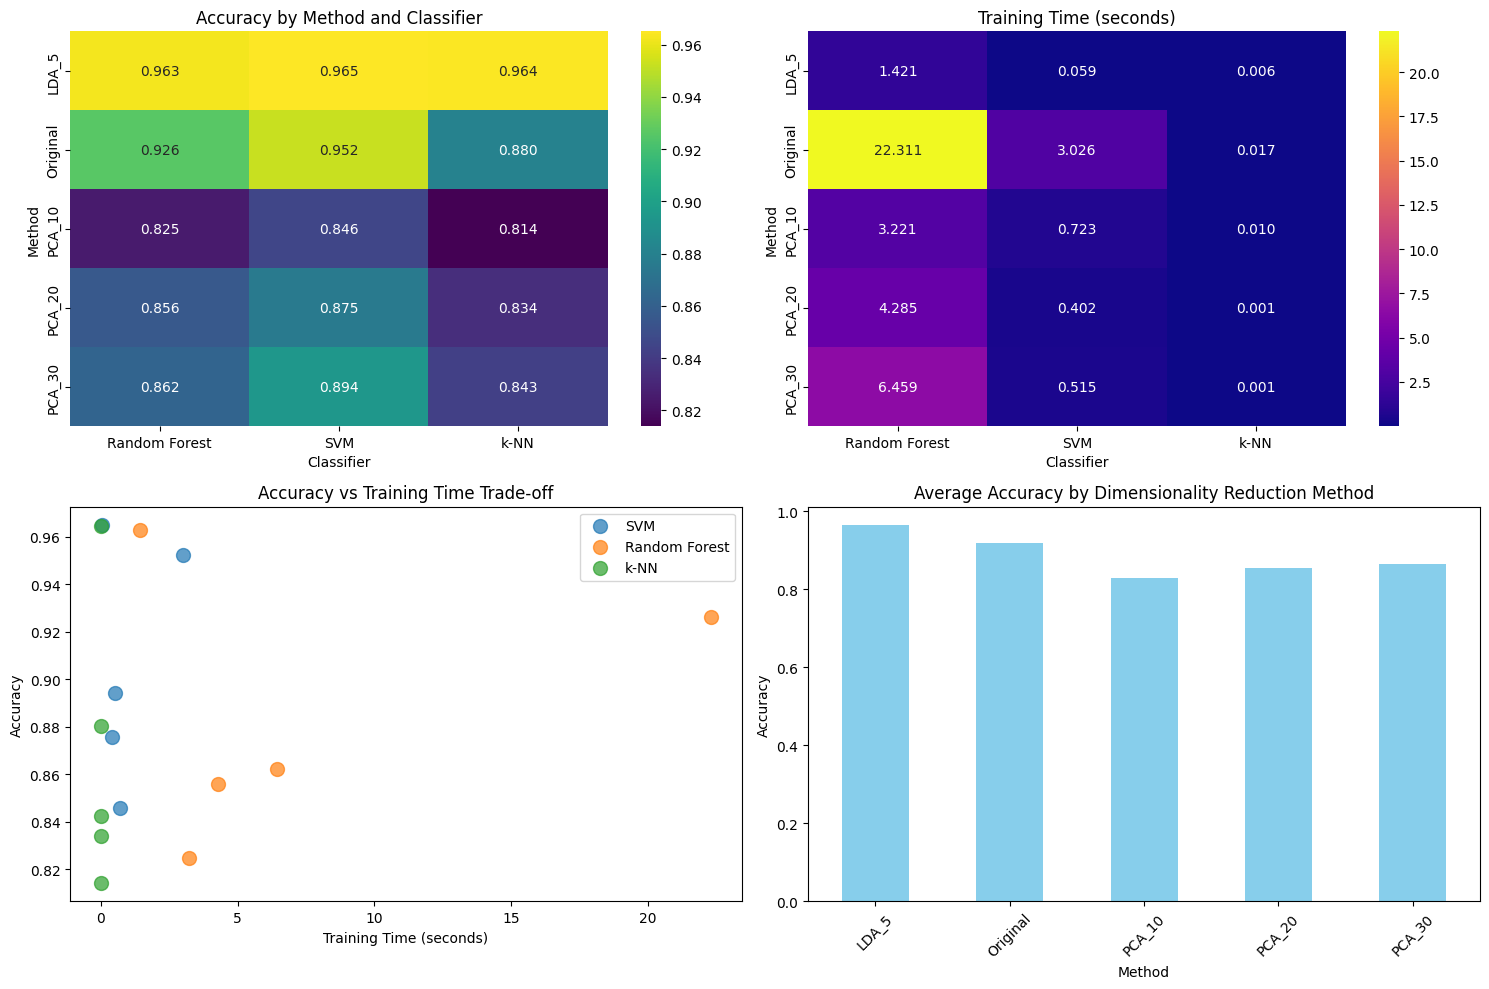

In [9]:
def create_visualizations(results_df):
    """
    Create visualizations for the results
    """

    # 1. Accuracy comparison
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    pivot_accuracy = results_df.pivot(index='Method', columns='Classifier', values='Accuracy')
    sns.heatmap(pivot_accuracy, annot=True, cmap='viridis', fmt='.3f')
    plt.title('Accuracy by Method and Classifier')

    # 2. Training time comparison
    plt.subplot(2, 2, 2)
    pivot_time = results_df.pivot(index='Method', columns='Classifier', values='Training_Time')
    sns.heatmap(pivot_time, annot=True, cmap='plasma', fmt='.3f')
    plt.title('Training Time (seconds)')

    # 3. Accuracy vs Training Time scatter plot
    plt.subplot(2, 2, 3)
    for classifier in results_df['Classifier'].unique():
        data = results_df[results_df['Classifier'] == classifier]
        plt.scatter(data['Training_Time'], data['Accuracy'],
                   label=classifier, s=100, alpha=0.7)
    plt.xlabel('Training Time (seconds)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Training Time Trade-off')
    plt.legend()

    # 4. Bar plot of accuracy by method
    plt.subplot(2, 2, 4)
    avg_accuracy = results_df.groupby('Method')['Accuracy'].mean()
    avg_accuracy.plot(kind='bar', color='skyblue')
    plt.title('Average Accuracy by Dimensionality Reduction Method')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.savefig('uci_har_results_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create visualizations
create_visualizations(results_df)


In [10]:
def analyze_results(results_df):
    """
    Perform detailed analysis of results
    """
    print("=== DETAILED ANALYSIS ===\n")

    # 1. Best performing combinations
    best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
    print(f"Best Accuracy: {best_accuracy['Accuracy']:.4f}")
    print(f"Method: {best_accuracy['Method']}, Classifier: {best_accuracy['Classifier']}\n")

    # 2. Fastest training
    fastest_training = results_df.loc[results_df['Training_Time'].idxmin()]
    print(f"Fastest Training: {fastest_training['Training_Time']:.4f} seconds")
    print(f"Method: {fastest_training['Method']}, Classifier: {fastest_training['Classifier']}\n")

    # 3. Best accuracy-speed trade-off (efficiency score)
    results_df['Efficiency_Score'] = results_df['Accuracy'] / results_df['Training_Time']
    best_efficiency = results_df.loc[results_df['Efficiency_Score'].idxmax()]
    print(f"Best Efficiency Score: {best_efficiency['Efficiency_Score']:.4f}")
    print(f"Method: {best_efficiency['Method']}, Classifier: {best_efficiency['Classifier']}\n")

    # 4. Average performance by method
    print("Average Performance by Method:")
    method_avg = results_df.groupby('Method').agg({
        'Accuracy': 'mean',
        'Training_Time': 'mean',
        'Inference_Time': 'mean'
    }).round(4)
    print(method_avg)

    # 5. Performance degradation analysis
    print("\n=== DIMENSIONALITY REDUCTION IMPACT ===")
    original_avg = results_df[results_df['Method'] == 'Original']['Accuracy'].mean()

    for method in ['PCA_10', 'PCA_20', 'PCA_30', 'LDA_5']:
        if method in results_df['Method'].values:
            method_avg_acc = results_df[results_df['Method'] == method]['Accuracy'].mean()
            degradation = ((original_avg - method_avg_acc) / original_avg) * 100
            print(f"{method}: {degradation:.2f}% accuracy loss, Avg Accuracy: {method_avg_acc:.4f}")

# Run analysis
analyze_results(results_df)


=== DETAILED ANALYSIS ===

Best Accuracy: 0.9650
Method: LDA_5, Classifier: SVM

Fastest Training: 0.0014 seconds
Method: PCA_20, Classifier: k-NN

Best Efficiency Score: 583.2506
Method: PCA_20, Classifier: k-NN

Average Performance by Method:
          Accuracy  Training_Time  Inference_Time
Method                                           
LDA_5       0.9640         0.4951          0.0439
Original    0.9195         8.4513          2.3773
PCA_10      0.8282         1.3181          0.3511
PCA_20      0.8551         1.5628          0.2310
PCA_30      0.8663         2.3253          0.2624

=== DIMENSIONALITY REDUCTION IMPACT ===
PCA_10: 9.93% accuracy loss, Avg Accuracy: 0.8282
PCA_20: 7.00% accuracy loss, Avg Accuracy: 0.8551
PCA_30: 5.78% accuracy loss, Avg Accuracy: 0.8663
LDA_5: -4.85% accuracy loss, Avg Accuracy: 0.9640


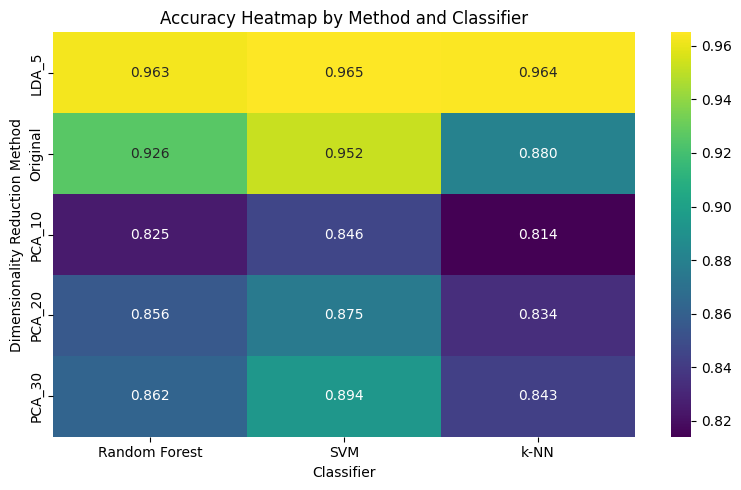

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load your results DataFrame (replace path if needed)
results_df = pd.read_csv('uci_har_dimensionality_reduction_results.csv')

# Create a pivot table for the heatmap
pivot_accuracy = results_df.pivot(index='Method', columns='Classifier', values='Accuracy')

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_accuracy, annot=True, fmt='.3f', cmap='viridis')
plt.title('Accuracy Heatmap by Method and Classifier')
plt.ylabel('Dimensionality Reduction Method')
plt.xlabel('Classifier')
plt.tight_layout()
plt.savefig('accuracy_heatmap.png', dpi=300)
plt.show()


/tmp/ipython-input-977866194.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_accuracy.index, y=avg_accuracy.values, palette='deep')


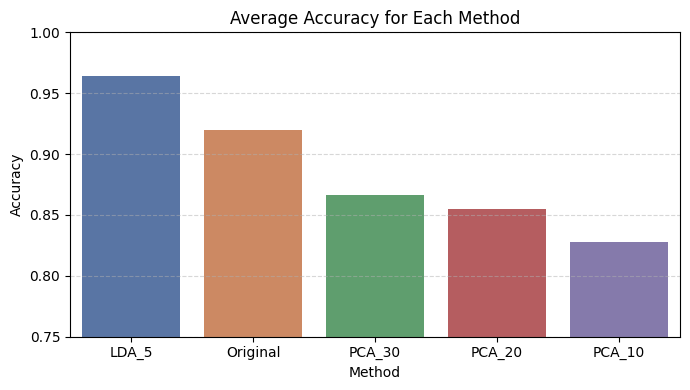

In [12]:
plt.figure(figsize=(7, 4))
avg_accuracy = results_df.groupby('Method')['Accuracy'].mean().sort_values(ascending=False)
sns.barplot(x=avg_accuracy.index, y=avg_accuracy.values, palette='deep')
plt.title('Average Accuracy for Each Method')
plt.ylabel('Accuracy')
plt.xlabel('Method')
plt.ylim(0.75, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('average_accuracy_bar.png', dpi=300)
plt.show()


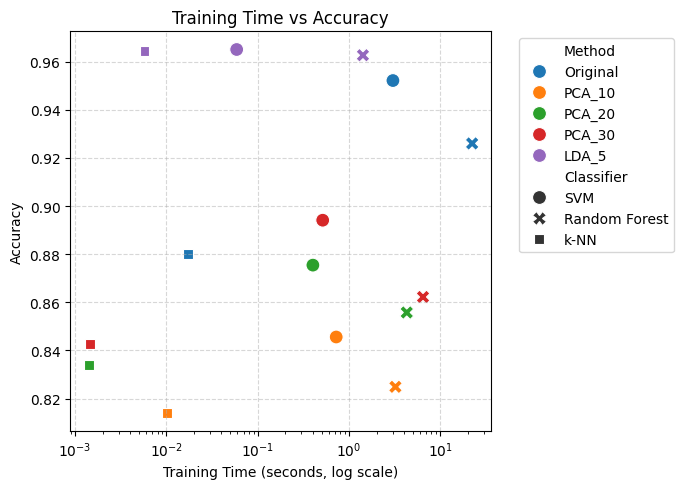

In [13]:
plt.figure(figsize=(7, 5))
sns.scatterplot(
    data=results_df,
    x='Training_Time', y='Accuracy',
    hue='Method', style='Classifier', s=100
)
plt.title('Training Time vs Accuracy')
plt.xlabel('Training Time (seconds, log scale)')
plt.xscale('log')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('training_time_vs_accuracy.png', dpi=300)
plt.show()


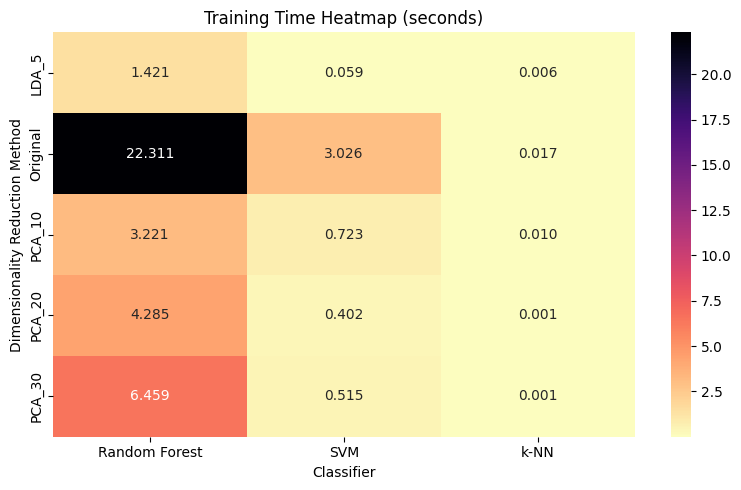

In [14]:
pivot_train = results_df.pivot(index='Method', columns='Classifier', values='Training_Time')

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_train, annot=True, fmt='.3f', cmap='magma_r')
plt.title('Training Time Heatmap (seconds)')
plt.ylabel('Dimensionality Reduction Method')
plt.xlabel('Classifier')
plt.tight_layout()
plt.savefig('training_time_heatmap.png', dpi=300)
plt.show()
